In [67]:
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import collections
import math
import os
import random
import zipfile
from six.moves import urllib
from six.moves import xrange  

%matplotlib inline 

In [69]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [79]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [91]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5244, 3083, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [116]:

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=1, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

10716 pejorative -> 6 a
215 way -> 7 to
7 to -> 1326 describe
1326 describe -> 105 any
105 any -> 1326 describe
455 act -> 20 that
20 that -> 455 act
59 used -> 2732 violent


In [127]:
print(batch.shape)
print(labels.shape)
      
train_inputs = tf.placeholder(tf.int32, shape=[128])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[128, 1])
# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, 128], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([vocabulary_size, 128],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 64, vocabulary_size))

# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.initialize_all_variables().run()

    for step in range(5000):
        batch_inputs, batch_labels = generate_batch(128, num_skips=1, skip_window=1)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}       
        _, loss_val = sess.run([train_op, loss],
                feed_dict=feed_dict)
        if step % 100 == 0:
            print("Loss at %d: %.5f" % (step, loss_val)) # Report the loss

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()




(8,)
(8, 1)
Loss at 0: 325.48300
Loss at 100: 238.33051
Loss at 200: 330.05463
Loss at 300: 240.46252
Loss at 400: 190.49278
Loss at 500: 259.09628
Loss at 600: 259.77069
Loss at 700: 233.75589
Loss at 800: 201.61243
Loss at 900: 320.19623
Loss at 1000: 308.75595
Loss at 1100: 271.16638
Loss at 1200: 298.29608
Loss at 1300: 378.90076
Loss at 1400: 199.50027
Loss at 1500: 243.59950
Loss at 1600: 205.17902
Loss at 1700: 283.05164
Loss at 1800: 292.00635
Loss at 1900: 229.17348
Loss at 2000: 196.87582
Loss at 2100: 439.52667
Loss at 2200: 290.79004
Loss at 2300: 177.28094
Loss at 2400: 388.90717
Loss at 2500: 241.20641
Loss at 2600: 406.30637
Loss at 2700: 137.68436
Loss at 2800: 212.12700
Loss at 2900: 255.32715
Loss at 3000: 143.19652
Loss at 3100: 228.03403
Loss at 3200: 296.01056
Loss at 3300: 274.46356
Loss at 3400: 352.00769
Loss at 3500: 249.66000
Loss at 3600: 288.23688
Loss at 3700: 496.93945
Loss at 3800: 260.47083
Loss at 3900: 138.18135
Loss at 4000: 309.79248
Loss at 4100: 40

Initialized
Average loss at step  0 :  257.014770508
Nearest to they: catalyse, electrode, late, claudio, winners, masorti, worries, franjo,
Nearest to however: deontological, krag, raul, helpless, healthy, hobson, parliamentarian, orange,
Nearest to th: ambulatory, necrosis, cheshire, intern, whammy, move, norwegians, beastie,
Nearest to at: pawns, nature, encouraging, inherit, anywhere, stanshall, overturned, box,
Nearest to such: vanishes, ghola, iberian, encroachment, barisan, tearing, report, integrin,
Nearest to one: housman, eutyches, enjoy, geddes, grille, gondwana, snare, sylvester,
Nearest to while: champaign, doth, camera, mark, greed, epicurus, distrust, boldness,
Nearest to between: mossad, misinformation, nikaya, cirth, kris, extradition, counterattack, livius,
Nearest to most: stadtholder, gwen, brilliantly, patagonian, imaginations, purification, kinshasa, labels,
Nearest to d: caves, vinyl, racquets, scavenge, precursor, bucaram, assertions, oliva,
Nearest to his: gogh

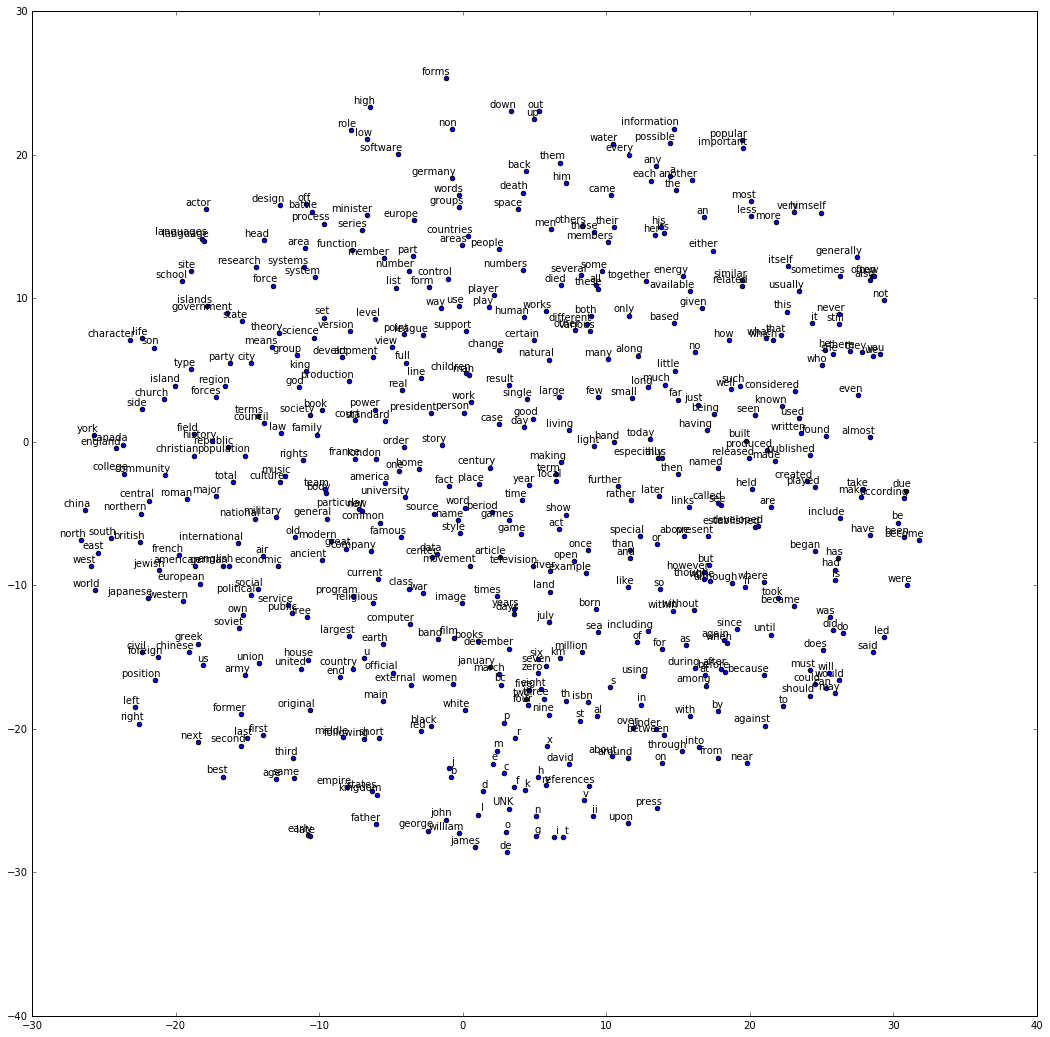

In [129]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.initialize_all_variables()

# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn and matplotlib to visualize embeddings.")